## Training a Physics-Informed Neural Network (PINN) for Martian Seismic Velocities

#### Now that data processing and visualization are complete, we will implement the PINN for simulating P-wave (Vp) and S-wave (Vs) velocities.

In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.autograd import grad
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

## MarsSeismic PINN Model
#### This code defines an improved version of the Mars Seismic Physics-Informed Neural Network (PINN), which utilizes Tanh activation for better handling of physics-based constraints.
#### Activation Function: Tanh is used instead of Swish to improve the network's behavior in terms of stability and physical model handling, especially for scenarios requiring smooth and bounded output.
#### Network Architecture: The network uses fully connected layers (nn.Linear) and applies Xavier uniform initialization for the weights and zero initialization for biases.
#### Forward Pass:The forward pass applies the Tanh activation to all layers except the output layer, where raw predictions are returned.

In [25]:

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
class ImprovedMarsSeismicPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()  
        self.fc_layers = nn.ModuleList()

        for i in range(len(layers)-1):
            layer = nn.Linear(layers[i], layers[i+1])
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            self.fc_layers.append(layer)

    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = self.activation(layer(x))
        return self.fc_layers[-1](x)


## Data Preprocessing and Physics-based Residual Calculation

#### This code snippet consists of two key functions: **`load_and_preprocess_data`** and **`compute_wave_equation_residual`**.

#### The **`load_and_preprocess_data`** function is responsible for loading seismic data from a file, specifically designed for Martian seismic waves. It reads the data, trims any extra whitespace in the column names, and normalizes the selected numerical columns (radius, vpv, vph, vsv, and vsh) by subtracting their mean and dividing by their standard deviation to standardize the input features for the model.

#### The **`compute_wave_equation_residual`** function calculates the residuals for the seismic wave propagation equations (P-wave and S-wave equations). It performs **automatic differentiation** to compute the first and second derivatives of the predicted velocities with respect to the radius. These residuals represent how well the model's predictions align with the physical wave propagation constraints, specifically the **second-order wave equations** for P-waves and S-waves. The residuals are used to enforce the **physics-informed loss function**, helping the model learn solutions consistent with seismic wave physics. The function returns the residuals for P-waves and S-waves, which are then utilized during training to update the model parameters effectively.


In [39]:

# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True)
    data.columns = [col.strip() for col in data.columns]
    numeric_columns = ['radius', 'vpv', 'vph', 'vsv', 'vsh']
    data[numeric_columns] = (data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std()
    return data
def load_and_preprocess_data1(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True)
    return data['vpv'].mean(), data['vph'].mean(), data['vsv'].mean(), data['vsh'].mean(), data['vpv'].std(), data['vph'].std(), data['vsv'].std(), data['vsh'].std()

              
# Physics-based PDE residuals
def compute_wave_equation_residual(model, x):
    x.requires_grad = True
    velocities = model(x)
    vpv, vph, vsv, vsh = velocities[:, 0], velocities[:, 1], velocities[:, 2], velocities[:, 3]

    dvpv_dr = grad(vpv.sum(), x, create_graph=True)[0]
    dvph_dr = grad(vph.sum(), x, create_graph=True)[0]
    dvsv_dr = grad(vsv.sum(), x, create_graph=True)[0]
    dvsh_dr = grad(vsh.sum(), x, create_graph=True)[0]

    d2vpv_dr2 = grad(dvpv_dr.sum(), x, create_graph=True)[0]
    d2vph_dr2 = grad(dvph_dr.sum(), x, create_graph=True)[0]
    d2vsv_dr2 = grad(dvsv_dr.sum(), x, create_graph=True)[0]
    d2vsh_dr2 = grad(dvsh_dr.sum(), x, create_graph=True)[0]

    # Modified PDE loss for better stability
    p_wave_residual = d2vpv_dr2 + 2/x * dvpv_dr
    p_wave_residual_h = d2vph_dr2 + 2/x * dvph_dr
    s_wave_residual = d2vsv_dr2 + 2/x * dvsv_dr
    s_wave_residual_h = d2vsh_dr2 + 2/x * dvsh_dr

    return [p_wave_residual, p_wave_residual_h, s_wave_residual, s_wave_residual_h]


## Training the Physics-Informed Neural Network (PINN)

#### The `train_pinn` function trains a Physics-Informed Neural Network (PINN) model on the seismic data for a set number of epochs. The function uses the AdamW optimizer with weight decay for regularization and the `ReduceLROnPlateau` scheduler to adjust the learning rate based on the plateau of the loss function. The training loop samples random batches of data for each epoch, computes both the data loss (mean squared error between predicted and actual velocities) and the physics loss (based on the wave equation residuals), and combines these losses to form the total loss. To avoid instability, gradient clipping is applied to the model parameters. The function prints the loss values every 1000 epochs for monitoring the model's training progress and returns a dictionary containing the total loss, data loss, and physics loss for each epoch.


In [27]:

# Training function
def train_pinn(model, data, epochs=20000, batch_size=64):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=1000, min_lr=1e-5)
    
    X = torch.FloatTensor(data[['radius']].values)
    y = torch.FloatTensor(data[['vpv', 'vph', 'vsv', 'vsh']].values)
    
    losses = {'total': [], 'data_mse': [], 'physics_pde': []}

    for epoch in range(epochs):
        idx = np.random.choice(len(X), batch_size)
        X_batch = X[idx]
        y_batch = y[idx]

        y_pred = model(X_batch)
        data_loss = torch.mean((y_pred - y_batch)**2)

        residuals = compute_wave_equation_residual(model, X_batch)
        physics_loss = sum(torch.mean(r**2) for r in residuals)
        
        loss = data_loss + 0.001 * physics_loss  

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(loss)

        losses['total'].append(loss.item())
        losses['data_mse'].append(data_loss.item())
        losses['physics_pde'].append(physics_loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}, Data Loss: {data_loss.item():.6f}, PDE Loss: {physics_loss.item():.6f}")

    return losses


### Model Training and Evaluation for Seismic Velocity Prediction

#### This code trains a **Physics-Informed Neural Network (PINN)** for predicting seismic velocity profiles (P-wave and S-wave) based on radial distance. The model is built with an increased depth (300-350-300-250 neurons) to improve fitting capabilities. It uses the **ImprovedMarsSeismicPINN** architecture to predict four velocity components: `vpv` (vertical P-wave velocity), `vph` (horizontal P-wave velocity), `vsv` (vertical S-wave velocity), and `vsh` (horizontal S-wave velocity). The training process runs for **20,000 epochs**, adjusting weights based on the **data loss** and **physics-based PDE residual loss**. After training, the results are plotted, comparing the predicted velocities against the actual data. The `plot_results` function generates a series of subplots for each velocity component, providing a visual representation of how well the model captures the actual seismic profile.


/var/folders/cl/4zbw16hj6qb2lgkgb2840sb80000gn/T/ipykernel_11045/3140821631.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


Epoch 1000, Loss: 0.609288, Data Loss: 0.521038, PDE Loss: 88.250031
Epoch 2000, Loss: 0.476693, Data Loss: 0.366317, PDE Loss: 110.376808
Epoch 3000, Loss: 0.333332, Data Loss: 0.288613, PDE Loss: 44.718426
Epoch 4000, Loss: 0.190507, Data Loss: 0.148302, PDE Loss: 42.205109
Epoch 5000, Loss: 0.330482, Data Loss: 0.264160, PDE Loss: 66.321922
Epoch 6000, Loss: 0.305488, Data Loss: 0.245808, PDE Loss: 59.679741
Epoch 7000, Loss: 0.505084, Data Loss: 0.434685, PDE Loss: 70.398834
Epoch 8000, Loss: 0.138347, Data Loss: 0.076737, PDE Loss: 61.610489
Epoch 9000, Loss: 0.363346, Data Loss: 0.320495, PDE Loss: 42.850563
Epoch 10000, Loss: 0.185449, Data Loss: 0.153628, PDE Loss: 31.820818
Epoch 11000, Loss: 0.357572, Data Loss: 0.322208, PDE Loss: 35.363842
Epoch 12000, Loss: 0.127603, Data Loss: 0.087103, PDE Loss: 40.499699
Epoch 13000, Loss: 0.749381, Data Loss: 0.711039, PDE Loss: 38.341663
Epoch 14000, Loss: 0.347203, Data Loss: 0.297932, PDE Loss: 49.271027
Epoch 15000, Loss: 0.180101,

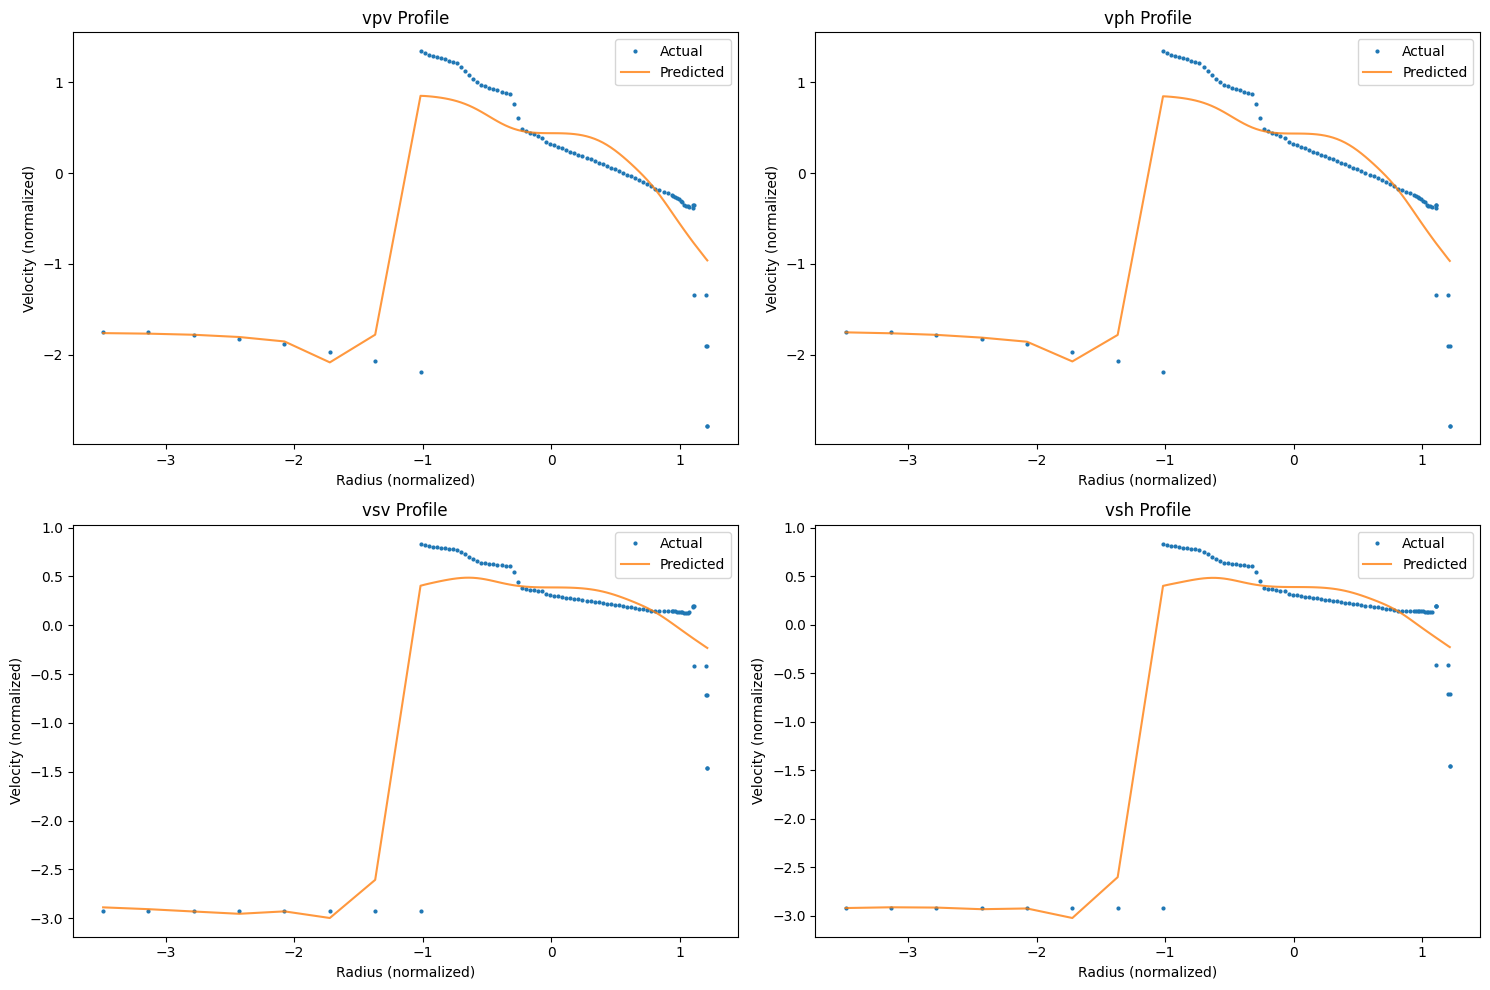

In [28]:

# Plot results
def plot_results(model, data):
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        X = torch.FloatTensor(data[['radius']].values)
        y_pred = model(X).numpy()

    velocity_components = ['vpv', 'vph', 'vsv', 'vsh']
    
    for i, vel in enumerate(velocity_components):
        plt.subplot(2, 2, i+1)
        plt.plot(data['radius'], data[vel], 'o', label='Actual', markersize=2)
        plt.plot(data['radius'], y_pred[:, i], '-', label='Predicted', alpha=0.8)
        plt.title(f'{vel} Profile')
        plt.xlabel('Radius (normalized)')
        plt.ylabel('Velocity (normalized)')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Execute model training and evaluation
data = load_and_preprocess_data('Data_module-7/DWAK.bm')

# Increased model depth for better fitting
model = ImprovedMarsSeismicPINN(layers=[1, 300, 350, 300, 250, 4])

losses = train_pinn(model, data, epochs=20000)
plot_results(model, data)


## Calculation of Refraction angle of P waves using the PINN model

Velocity of P wave in core: 7273.83 m/s
Velocity of P wave in mantle: 8981.89 m/s
Critical angle: 54.08 degrees

Incident and Refraction Angles:
Incident Angle (°)  Refraction Angle (°)
----------------------------------------
0.00                0.00                
1.00                1.23                
2.00                2.47                
3.00                3.71                
4.00                4.94                
5.00                6.18                
6.00                7.42                
7.00                8.66                
8.00                9.90                
9.00                11.14               
10.00               12.38               
11.00               13.63               
12.00               14.88               
13.00               16.13               
14.00               17.38               
15.00               18.64               
16.00               19.90               
17.00               21.16               
18.00               22.43          

/var/folders/cl/4zbw16hj6qb2lgkgb2840sb80000gn/T/ipykernel_11045/3559559308.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


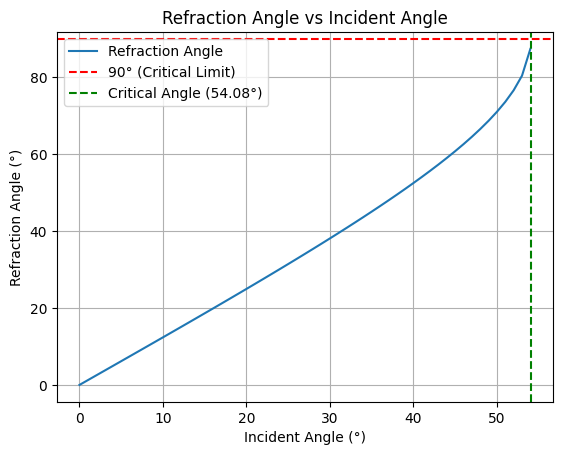

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define Snell's Law for refraction calculation
def snells_law(v1, v2, theta1):
    """Calculate refraction angle using Snell's Law."""
    return torch.asin((v1 / v2) * torch.sin(theta1))

# Function to calculate the critical angle
def calculate_critical_angle(v1, v2):
    """Calculate the critical angle for total internal reflection."""
    # Convert inputs to tensors if they are not tensors
    if not isinstance(v1, torch.Tensor):
        v1 = torch.tensor(v1, dtype=torch.float32)
    if not isinstance(v2, torch.Tensor):
        v2 = torch.tensor(v2, dtype=torch.float32)

    if v1 <= v2:
        print("Total internal reflection is not possible since v1 ≤ v2.")
        return None
    
    critical_angle = torch.asin(v2 / v1)
    critical_angle_deg = critical_angle.item() * 180 / np.pi
    print(f"Critical angle: {critical_angle_deg:.2f} degrees")
    return critical_angle_deg

# Function to calculate refraction angles and paths at the core-mantle boundary
def calculate_boundary_refraction(model, core_mantle_boundary, mean_vals, std_vals):
    with torch.no_grad():
        # Get velocities on both sides of the boundary
        boundary_tensor_core = torch.FloatTensor([[core_mantle_boundary - 0.25]])
        boundary_tensor_mantle = torch.FloatTensor([[core_mantle_boundary + 0.1]])
        
        velocities_core = model(boundary_tensor_core)
        velocities_mantle = model(boundary_tensor_mantle)

        # Extract and un-normalize velocities
        vp_core_norm, vs_core_norm = velocities_core[0, 0], velocities_core[0, 2]
        vp_mantle_norm, vs_mantle_norm = velocities_mantle[0, 0], velocities_mantle[0, 2]

        vp_core = vp_core_norm * std_vals['vpv'] + mean_vals['vpv']
        vp_mantle = vp_mantle_norm * std_vals['vpv'] + mean_vals['vpv']
        
        print(f"Velocity of P wave in core: {vp_core:.2f} m/s")
        print(f"Velocity of P wave in mantle: {vp_mantle:.2f} m/s")

        return vp_core.item(), vp_mantle.item()

# Function to iterate and print refraction angles
def calculate_and_print_refraction_angles(v1, v2, initial_angle=0.0, angle_step=1.0):
    """Calculate and print refraction angles for incident angles until the critical angle is reached."""
    critical_angle_deg = calculate_critical_angle(v1, v2)
    if critical_angle_deg is None:
        return

    print("\nIncident and Refraction Angles:")
    print(f"{'Incident Angle (°)':<20}{'Refraction Angle (°)':<20}")
    print("-" * 40)

    # Iterate through incident angles and calculate refraction angles
    while initial_angle < critical_angle_deg:
        theta1 = torch.tensor(np.radians(initial_angle), dtype=torch.float32)
        refraction_angle_p = snells_law(v1, v2, theta1)
        refraction_angle_deg = refraction_angle_p.item() * 180 / np.pi

        print(f"{initial_angle:<20.2f}{refraction_angle_deg:<20.2f}")
        initial_angle += angle_step

# Function to visualize refraction angles
def plot_refraction_angles(v1, v2, critical_angle_deg, angle_step=1.0):
    """Plot incident vs. refraction angles up to the critical angle."""
    incident_angles = []
    refraction_angles = []

    # Convert inputs to tensors if needed
    if not isinstance(v1, torch.Tensor):
        v1 = torch.tensor(v1, dtype=torch.float32)
    if not isinstance(v2, torch.Tensor):
        v2 = torch.tensor(v2, dtype=torch.float32)

    # Calculate refraction angles for plotting
    for initial_angle in np.arange(0, critical_angle_deg, angle_step):
        theta1 = torch.tensor(np.radians(initial_angle), dtype=torch.float32)
        refraction_angle_p = snells_law(v1, v2, theta1)
        refraction_angle_deg = refraction_angle_p.item() * 180 / np.pi

        incident_angles.append(initial_angle)
        refraction_angles.append(refraction_angle_deg)

    # Plot the results
    plt.plot(incident_angles, refraction_angles, label="Refraction Angle")
    plt.axhline(y=90, color='r', linestyle='--', label="90° (Critical Limit)")
    plt.axvline(x=critical_angle_deg, color='g', linestyle='--', label=f"Critical Angle ({critical_angle_deg:.2f}°)")
    plt.xlabel("Incident Angle (°)")
    plt.ylabel("Refraction Angle (°)")
    plt.title("Refraction Angle vs Incident Angle")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
vpvm, vphm, vsvm, vshm, vpvs, vphs, vsvs, vshs = load_and_preprocess_data1('Data_module-7/DWAK.bm')
mean_values = {'vpv': vpvm, 'vsv': vsvm}  # Replace with actual mean values from your data
std_values = {'vpv': vpvs, 'vsv': vsvs}   # Replace with actual std values from your data
core_mantle_boundary_radius = -1  # Example core-mantle boundary radius in km

vp_core, vp_mantle = calculate_boundary_refraction(model, core_mantle_boundary_radius, mean_values, std_values)

calculate_and_print_refraction_angles(vp_mantle, vp_core)
critical_angle_deg = calculate_critical_angle(vp_mantle, vp_core)
if critical_angle_deg is not None:
    plot_refraction_angles(vp_mantle, vp_core, critical_angle_deg)
